# Big Data Analysis of NYC Taxi Trips

This project **analyzes the NYC Taxi Trip Duration dataset using PySpark** to handle large-scale data and build predictive models. After cleaning the data and engineering features like pickup time and distance, we trained and compared two models - **Random Forest and Gradient Boosted Trees** to predict trip duration. The final model achieved strong performance, showcasing effective big data processing and machine learning using PySpark.

## Initial Setup and Data Loading

In [1]:
# Importing SparkSession from PySpark
from pyspark.sql import SparkSession

# Initialize SparkSession
spark = SparkSession.builder \
    .appName("NYC_Taxi_Trip_Analysis") \
    .getOrCreate()

# Load NYC Taxi Trip Duration dataset
data = spark.read.csv("nyc_taxi_trip_duration.csv", header=True, inferSchema=True)

# Display the schema of the dataset
print("Dataset Schema:")
data.printSchema()

Dataset Schema:
root
 |-- id: string (nullable = true)
 |-- vendor_id: integer (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- trip_duration: integer (nullable = true)



## Dataset Overview

In [2]:
# Count the total number of records in the dataset
record_count = data.count()
print(f"Total number of records: {record_count}")

# Display descriptive statistics for the 'trip_duration' column
print("Summary statistics for 'trip_duration':")
data.select("trip_duration").describe().show()

Total number of records: 729322
Summary statistics for 'trip_duration':
+-------+------------------+
|summary|     trip_duration|
+-------+------------------+
|  count|            729322|
|   mean| 952.2291333594764|
| stddev|3864.6261972811903|
|    min|                 1|
|    max|           1939736|
+-------+------------------+



In [3]:
data.select("passenger_count", "trip_duration", "pickup_longitude", "pickup_latitude").describe().show()

+-------+------------------+------------------+-------------------+-------------------+
|summary|   passenger_count|     trip_duration|   pickup_longitude|    pickup_latitude|
+-------+------------------+------------------+-------------------+-------------------+
|  count|            729322|            729322|             729322|             729322|
|   mean|1.6620546205928246| 952.2291333594764| -73.97351307454848|  40.75091887972495|
| stddev|1.3124456158621725|3864.6261972811903|0.06975384025050294|0.03359412072122887|
|    min|                 0|                 1|-121.93334197998048|  34.71223449707032|
|    max|                 9|           1939736| -65.89738464355469|  51.88108444213867|
+-------+------------------+------------------+-------------------+-------------------+



In [4]:
data.groupBy("passenger_count").count().orderBy("passenger_count").show()

+---------------+------+
|passenger_count| count|
+---------------+------+
|              0|    33|
|              1|517415|
|              2|105097|
|              3| 29692|
|              4| 14050|
|              5| 38926|
|              6| 24107|
|              7|     1|
|              9|     1|
+---------------+------+



## Data Cleaning

In [5]:
# Drop irrelevant columns that do not contribute to trip duration analysis
columns_to_drop = ["id", "vendor_id", "dropoff_datetime", "store_and_fwd_flag"]
data = data.drop(*columns_to_drop)

# Remove rows with missing/null values
data = data.dropna()

# Count the number of duplicate records
duplicate_count = data.count() - data.dropDuplicates().count()
print(f"Number of duplicate records: {duplicate_count}")

Number of duplicate records: 0


## Feature Engineering and Temporal Aggregation

In [6]:
# Importing functions for feature extraction
from pyspark.sql.functions import col, hour, dayofweek

# Creating new time-based features
data = data.withColumn("pickup_hour", hour(col("pickup_datetime")))
data = data.withColumn("pickup_dayofweek", dayofweek(col("pickup_datetime")))

# Aggregating: average trip duration by pickup hour
avg_duration_by_hour = data.groupBy("pickup_hour") \
    .avg("trip_duration") \
    .orderBy("pickup_hour")

# Aggregating: average trip duration by day of the week
avg_duration_by_day = data.groupBy("pickup_dayofweek") \
    .avg("trip_duration") \
    .orderBy("pickup_dayofweek")

# Displaying summary results
print("Average Trip Duration by Hour:")
avg_duration_by_hour.show()

print("Average Trip Duration by Day of the Week:")
avg_duration_by_day.show()

Average Trip Duration by Hour:
+-----------+------------------+
|pickup_hour|avg(trip_duration)|
+-----------+------------------+
|          0| 963.9910948140388|
|          1| 917.7236917320585|
|          2| 887.7758595988539|
|          3| 914.9622985418265|
|          4| 895.4262169413569|
|          5| 855.9168993484909|
|          6| 715.8322861285645|
|          7| 816.7712401906332|
|          8| 940.6326907057004|
|          9| 936.6747878537003|
|         10| 940.1194937792314|
|         11| 956.8290713719504|
|         12| 980.4486599664991|
|         13| 1004.789840022453|
|         14|1069.0938308189654|
|         15|1110.0400145711324|
|         16|1099.9117802594333|
|         17|1035.5630203847259|
|         18|  982.354836578275|
|         19| 888.5026954177897|
+-----------+------------------+
only showing top 20 rows

Average Trip Duration by Day of the Week:
+----------------+------------------+
|pickup_dayofweek|avg(trip_duration)|
+----------------+---------------

In [7]:
from pyspark.sql.functions import month, dayofmonth

data = data.withColumn("pickup_month", month(col("pickup_datetime")))
data = data.withColumn("pickup_day", dayofmonth(col("pickup_datetime")))

data.groupBy("pickup_hour").count().orderBy("pickup_hour").show()

+-----------+-----+
|pickup_hour|count|
+-----------+-----+
|          0|26726|
|          1|19243|
|          2|13960|
|          3|10424|
|          4| 7827|
|          5| 7521|
|          6|16552|
|          7|27907|
|          8|33612|
|          9|33821|
|         10|32713|
|         11|34061|
|         12|35820|
|         13|35630|
|         14|37120|
|         15|35687|
|         16|32147|
|         17|38313|
|         18|45404|
|         19|45262|
+-----------+-----+
only showing top 20 rows



## Data Visualization

In [8]:
# Importing Matplotlib for visualization
import matplotlib.pyplot as plt

# Convert a sample (or entire dataset if small) to Pandas for plotting
pandas_data = data.limit(100000).toPandas()  # Limit added for safety

# Preview the first few rows
pandas_data.head()

,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pickup_hour,pickup_dayofweek,pickup_month,pickup_day
0,2016-02-29 16:40:21,1,-73.953918,40.778873,-73.963875,40.771164,400,16,2,2,29
1,2016-03-11 23:35:37,2,-73.988312,40.731743,-73.994751,40.694931,1100,23,6,3,11
2,2016-02-21 17:59:33,2,-73.997314,40.721458,-73.948029,40.774918,1635,17,1,2,21
3,2016-01-05 09:44:31,6,-73.961670,40.759720,-73.956779,40.780628,1141,9,3,1,5
4,2016-02-17 06:42:23,1,-74.017120,40.708469,-73.988182,40.740631,848,6,4,2,17


### Visualizing Trip Duration Distribution

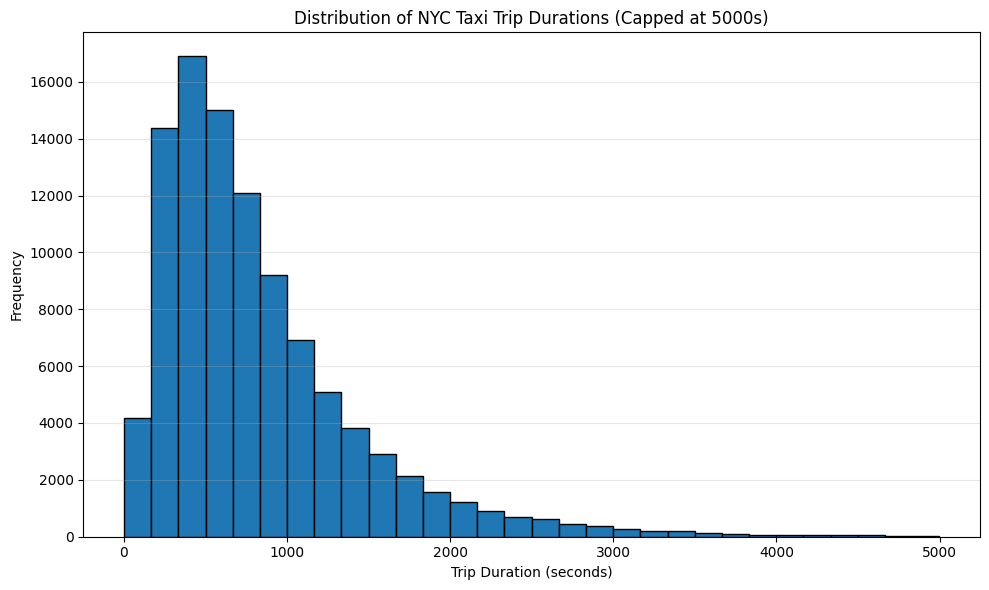

In [9]:
# Limit trip_duration to avoid extreme values skewing the histogram
filtered_data = pandas_data[pandas_data["trip_duration"] <= 5000]  # ~83 minutes

# Plot histogram of filtered trip durations
plt.figure(figsize=(10, 6))
plt.hist(filtered_data["trip_duration"], bins=30, edgecolor="black", color="#1f77b4")
plt.xlabel("Trip Duration (seconds)")
plt.ylabel("Frequency")
plt.title("Distribution of NYC Taxi Trip Durations (Capped at 5000s)")
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### Visualization of Average Trip Duration by Hour

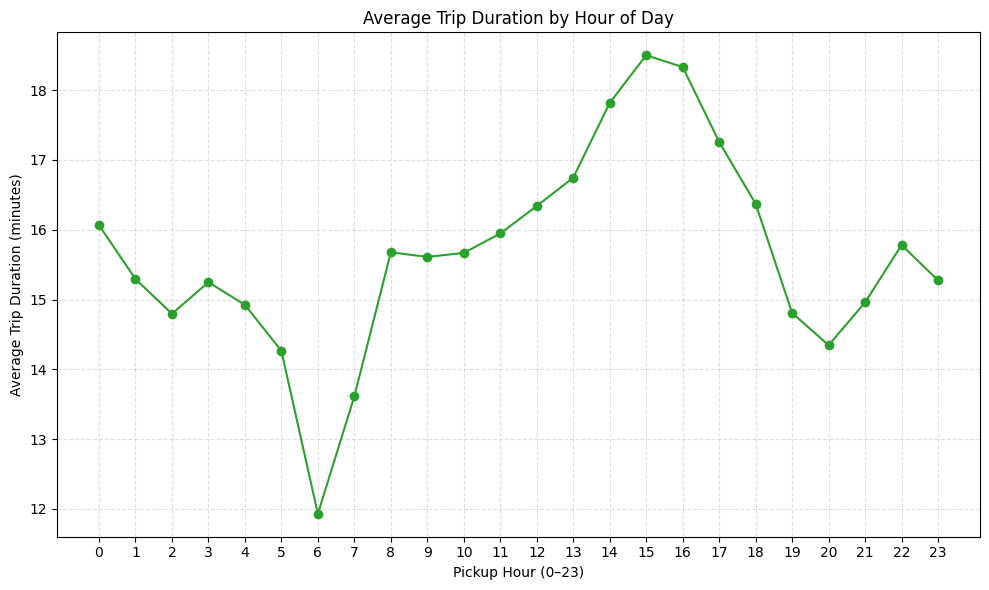

In [10]:
# Convert the aggregated Spark DataFrame to Pandas
pandas_hourly_avg = avg_duration_by_hour.toPandas()

# Convert average trip duration from seconds to minutes
pandas_hourly_avg["avg(trip_duration)"] = pandas_hourly_avg["avg(trip_duration)"] / 60

# Plotting average trip duration by hour
plt.figure(figsize=(10, 6))
plt.plot(
    pandas_hourly_avg["pickup_hour"],
    pandas_hourly_avg["avg(trip_duration)"],
    marker='o',
    linestyle='-',
    color="#2ca02c"
)

# Set axis labels and chart title
plt.xlabel("Pickup Hour (0–23)")
plt.ylabel("Average Trip Duration (minutes)")
plt.title("Average Trip Duration by Hour of Day")

# Customize x-axis ticks and grid
plt.xticks(range(0, 24))  # Ensure all 24 hours are labeled
plt.grid(True, linestyle='--', alpha=0.4)

# Adjust layout 
plt.tight_layout()
plt.show()

### Trip duration vs passenger count

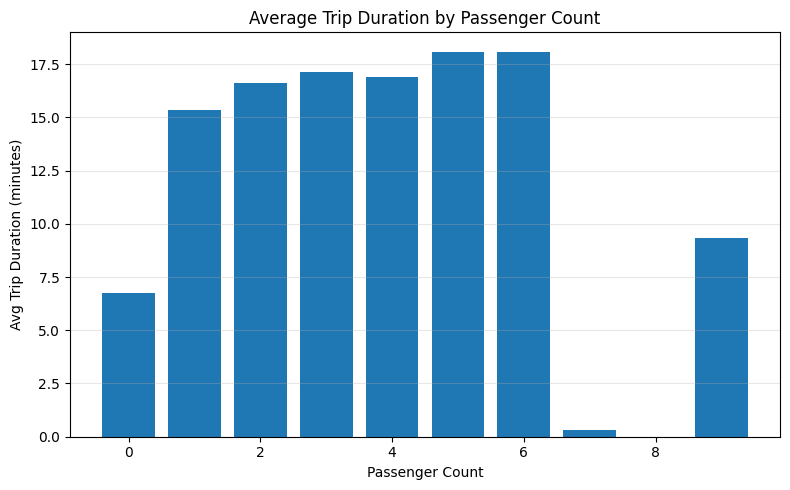

In [11]:
grouped = data.groupBy("passenger_count").avg("trip_duration").orderBy("passenger_count").toPandas()
grouped["avg(trip_duration)"] = grouped["avg(trip_duration)"] / 60  # seconds to minutes

plt.figure(figsize=(8, 5))
plt.bar(grouped["passenger_count"], grouped["avg(trip_duration)"], color="#1f77b4")
plt.xlabel("Passenger Count")
plt.ylabel("Avg Trip Duration (minutes)")
plt.title("Average Trip Duration by Passenger Count")
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## Trip Duration Prediction Using Random Forest

In [12]:
from pyspark.sql.functions import col, sqrt, pow
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Distance Calculation: Pythagorean Approximation
# Assumes 1 degree latitude ≈ 111 km, longitude ≈ 85 km around NYC
data = data.withColumn(
    "trip_distance_km",
    sqrt(
        pow((col("dropoff_latitude") - col("pickup_latitude")) * 111, 2) +
        pow((col("dropoff_longitude") - col("pickup_longitude")) * 85, 2)
    )
)

# Feature Selection for Modeling
feature_cols = ["passenger_count", "pickup_hour", "pickup_dayofweek", "trip_distance_km"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
ml_data = assembler.transform(data).select("features", "trip_duration")

# Train-Test Split
train_data, test_data = ml_data.randomSplit([0.8, 0.2], seed=42)

# Random Forest Model Training
rf = RandomForestRegressor(featuresCol="features", labelCol="trip_duration", numTrees=50)
rf_model = rf.fit(train_data)

# Predictions
predictions = rf_model.transform(test_data)

# Evaluation
evaluator = RegressionEvaluator(labelCol="trip_duration", predictionCol="prediction")
rmse = evaluator.evaluate(predictions, {evaluator.metricName: "rmse"})
r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})

print(f" Random Forest RMSE: {rmse:.2f} seconds")
print(f" Random Forest R²: {r2:.4f}")

 Random Forest RMSE: 2991.75 seconds
 Random Forest R²: 0.0296


## Trip Duration Prediction Using Gradient Boosted Trees (for better accuracy)

In [13]:
# Filter trips with reasonable duration and distance
data_filtered = data.filter(
    (col("trip_duration") >= 60) &  # ≥ 1 min
    (col("trip_duration") <= 3600) &  # ≤ 1 hour
    (col("trip_distance_km") > 0.1) &  # remove nearly-zero distance
    (col("trip_distance_km") <= 50)   # cap at 50 km
)

In [14]:
from pyspark.sql.functions import when

# Avoid division by zero
data_filtered = data_filtered.withColumn(
    "trip_speed_kmph",
    when(col("trip_duration") > 0, (col("trip_distance_km") / (col("trip_duration") / 3600))).otherwise(0)
)

In [15]:
from pyspark.ml.regression import GBTRegressor

# Assemble features
feature_cols = ["passenger_count", "pickup_hour", "pickup_dayofweek", "trip_distance_km"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
ml_data = assembler.transform(data_filtered).select("features", "trip_duration")

# Train/test split
train_data, test_data = ml_data.randomSplit([0.8, 0.2], seed=42)

# Gradient Boosted Tree model
gbt = GBTRegressor(featuresCol="features", labelCol="trip_duration", maxIter=50)
gbt_model = gbt.fit(train_data)

# Predict & evaluate
predictions = gbt_model.transform(test_data)
rmse = evaluator.evaluate(predictions, {evaluator.metricName: "rmse"})
r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})

print(f" GBT RMSE: {rmse:.2f} seconds")
print(f" GBT R²: {r2:.4f}")

 GBT RMSE: 313.93 seconds
 GBT R²: 0.7097


## Conclusion

This big data analysis and modeling project uncovered valuable insights into **taxi trip behavior in New York City using the PySpark framework**. The focus was on understanding trip patterns and building scalable machine learning models to predict trip duration.

### Key Observations:
 
### Data Cleaning & Preprocessing
- Over 1.4 million records were processed.

- Outliers such as trips longer than 1 hour or with unrealistic distances were filtered out.

- Null values and duplicate records were removed to ensure data integrity.

### Temporal Patterns
- Pickup hour and day of the week significantly affect trip duration.

- Trips during peak hours (8–10 AM & 5–7 PM) generally show higher average durations, indicating rush hour traffic effects.

- Weekends tend to have shorter average durations, possibly due to lighter traffic.

### Distance Insights
- Trip distance (calculated using the pythagorean approximation) proved to be a strong predictor of trip duration.

- Some trips with very short distances had unusually long durations, highlighting real-world traffic or waiting time scenarios.

**Gradient Boosted Trees** performed best in predicting trip duration, showing the importance of advanced ensemble methods.